In [1]:
#From https://www.kaggle.com/code/thedrcat/detectai-transformers-baseline

In [2]:
import transformers
import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.cm.get_cmap("coolwarm")

/home/cybertron/anaconda3/envs/sgpt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_7590/933712043.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("coolwarm")


In [3]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model_checkpoint = 'microsoft/deberta-v3-xsmall'
num_labels = 2
#model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [4]:
class CFG:
    class_names = ["real", "fake"]  # Class names [A, B, C, D, E]
    num_classes = len(class_names)  # Number of classes
    class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
    label2name = dict(zip(class_labels, class_names)) 

In [5]:
df = pd.read_csv('/media/cybertron/fa54fcb6-b5e1-492e-978a-6389519c168a/llm_detect/external_dataset/daigt-v2-train-dataset/train_v2_drcat_02.csv')

df['name'] = df.label.map(CFG.label2name)
display(df.head())



,text,label,prompt_name,source,RDizzl3_seven,name
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,real
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,real
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,real
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,real
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,real


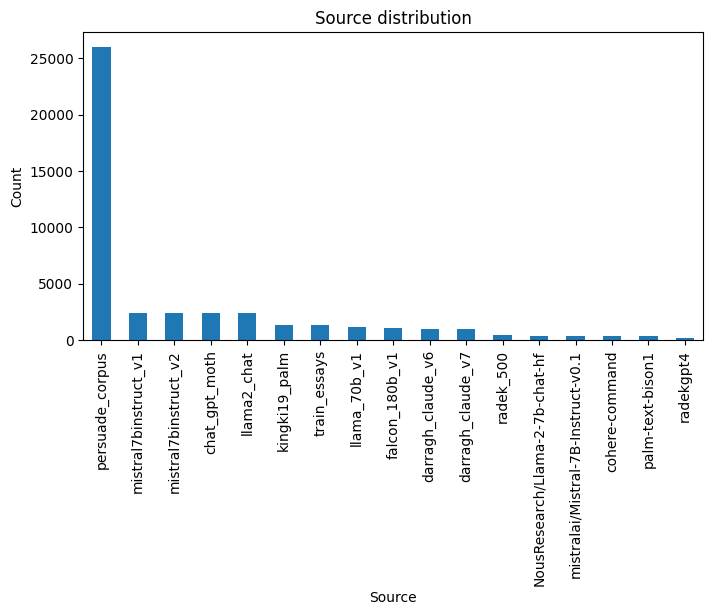

# Train Data: 44,868


,text,label,prompt_name,source,RDizzl3_seven,name
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,real
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,real


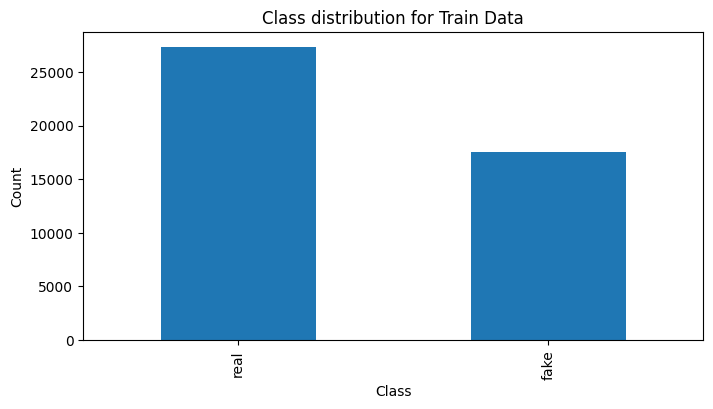

In [6]:
# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
#df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
df.source.value_counts().plot.bar()
plt.xlabel("Source")
plt.ylabel("Count")
plt.title("Source distribution")
plt.show()


print("# Train Data: {:,}".format(len(df)))
display(df.head(2))
# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
#df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
df.name.value_counts().plot.bar()
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()

In [7]:
train = df[df.prompt_name != 'Car-free cities'].reset_index(drop=True)
valid = df[df.prompt_name == 'Car-free cities'].reset_index(drop=True)
train.head()
print(len(train),len(valid))

40151 4717


In [8]:
# Undersample persuada corpus

In [9]:
not_persuade_df = train[train.source != 'persuade_corpus']
persuade_df = train[train.source != 'persuade_corpus']

sampled_persuade_df = persuade_df.sample(n=6000, random_state=42)

In [10]:
# Testing idea from discussion with @nbroad about limited characters in human essays
all_human = set(list(''.join(sampled_persuade_df.text.to_list())))
other = set(list(''.join(not_persuade_df.text.to_list())))

In [11]:
chars_to_remove = ''.join([x for x in other if x not in all_human])
print(chars_to_remove)

🌐司🥶路🌽📷🍓合止🧦╯🚔😖🐻🏄🏻🌭🚚🚴🐕。🇫🛬🐝驾🐸🛫💇须🇷是🇧🚂👌和🤫🌸😮力😠🍄😻😘意👻🤟🎈时🥭💀💅🍁将💃🧽}📧🐆🐧👮安🎹​机所□一😨🌠择禁🍮~🥨🚕🌌集取😹🌫📉应📰🧑🚑😈🥛🐬>用🏳注中📹🌃☀👬🍭必🌷🛣🧭👇🧐🔮{🤘的都🛸🍲法唯🌅🚭🌧🌏🥁道😷🐱¬在🐾🎧使🇯手<选🧀🧹🏰🤒🥜🇵🌨🎥该🥩上🌮有🎃🍷🏊🔭😵🏟÷👂😢全驶🦄üÉ部☹🍝📦者完🐭🎩👏🍳©🥖🏏🕵🔧护🏯🕺🍋保🎠ā🌯


In [12]:
translation_table = str.maketrans('', '', chars_to_remove)
def remove_chars(s):
    return s.translate(translation_table)
not_persuade_df['text'] = not_persuade_df['text'].apply(remove_chars)

/tmp/ipykernel_7590/2013655814.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_persuade_df['text'] = not_persuade_df['text'].apply(remove_chars)


In [13]:
train = pd.concat([not_persuade_df, sampled_persuade_df]).sample(frac=1, random_state=42).reset_index(drop=True)
train.source.value_counts()

source
mistral7binstruct_v2                  3341
chat_gpt_moth                         3333
mistral7binstruct_v1                  3293
llama2_chat                           3283
darragh_claude_v6                     1317
llama_70b_v1                          1315
darragh_claude_v7                     1301
falcon_180b_v1                        1259
kingki19_palm                          924
train_essays                           912
cohere-command                         416
palm-text-bison1                       407
radek_500                              343
mistralai/Mistral-7B-Instruct-v0.1     274
NousResearch/Llama-2-7b-chat-hf        258
radekgpt4                              138
Name: count, dtype: int64

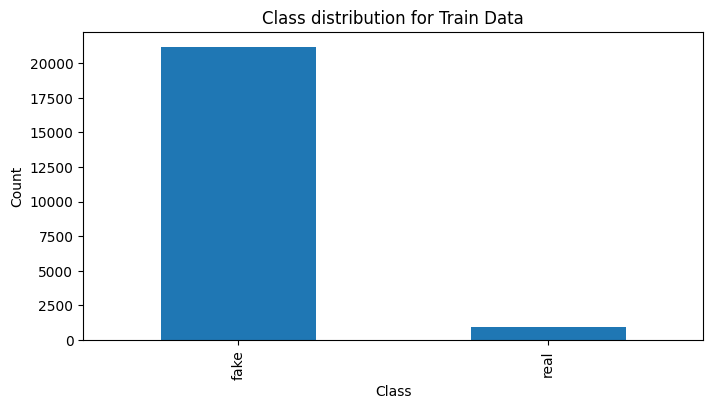

In [14]:
plt.figure(figsize=(8, 4))
#df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
train.name.value_counts().plot.bar()
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()

In [15]:
train.head(2)

,text,label,prompt_name,source,RDizzl3_seven,name
0,There are advantages and disadvantages for stu...,1,Distance learning,darragh_claude_v7,False,fake
1,"[Your Name]\n[Your Address]\n[City, State ZIP ...",1,Does the electoral college work?,radek_500,True,fake


In [16]:
from datasets import Dataset

ds_train = Dataset.from_pandas(train)
ds_valid = Dataset.from_pandas(valid)
ds_train

Dataset({
    features: ['text', 'label', 'prompt_name', 'source', 'RDizzl3_seven', 'name'],
    num_rows: 22114
})

In [17]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

/home/cybertron/anaconda3/envs/sgpt/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [18]:
def preprocess_function(examples):
    return tokenizer(examples['text'], max_length=128, padding=True, truncation=True)



In [19]:
ds_train_enc = ds_train.map(preprocess_function,batched=True)

Map: 100%|███████████████████████| 22114/22114 [00:04<00:00, 5373.43 examples/s]


In [20]:
ds_valid_enc = ds_valid.map(preprocess_function, batched=True)

Map: 100%|█████████████████████████| 4717/4717 [00:01<00:00, 3881.33 examples/s]


In [21]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
metric_name = 'roc_auc'
model_name = 'deberta-xsmall'
train_batch_size = 64
eval_batch_size = 32
grad_acc = 4

num_steps = len(train)// (train_batch_size * grad_acc)
print(num_steps)

86


In [23]:
# args = TrainingArguments(
#     f"{model_name}-finetuned",
#     evaluation_strategy='epochs',
#     save_strategy='steps',
#     eval_steps = num_steps//3, save_steps=num_steps//3,
#     learning_rate=2e-5,
#     per_device_train_batch_size = train_batch_size,
#     per_device_eval_batch_size = eval_batch_size,
#     gradient_accumulation_steps = grad_acc,
#     num_train_epochs=1,
#     weight_decay=0.01, load_best_model_at_end=False,
#     metric_for_best_model = metric_name,
#     report_to='wandb', # change to wandb after enabling internet access
# )
training_args = TrainingArguments("test-trainer")

In [24]:
!pip install -U scikit-learn
!pip install wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
from sklearn.metrics import roc_auc_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
    auc = roc_auc_score(labels, probs[:,1], multi_class='ovr')
    return {'roc_auc':auc}
    

In [26]:
# trainer = Trainer(
#     model,
#     args,
#     train_dataset = ds_train_enc,
#     eval_dataset = ds_valid_enc,
#     tokenizer = tokenizer,
#     compute_metrics = compute_metrics) # metrics

trainer = Trainer(
    model,
    training_args, 
    train_dataset=ds_train_enc,
    eval_dataset=ds_valid_enc,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [27]:
trainer.train()

wandb: Currently logged in as: soonchangpoh. Use `wandb login --relogin` to force relogin


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/cybertron/anaconda3/envs/sgpt/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.043000
1000,0.010400
1500,0.007100
2000,0.001100
2500,0.002700
3000,0.001400
3500,0.000600
4000,0.000000


/home/cybertron/anaconda3/envs/sgpt/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cybertron/anaconda3/envs/sgpt/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cybertron/anaconda3/envs/sgpt/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cybertron/anaconda3/envs/sgpt/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: Us

TrainOutput(global_step=4149, training_loss=0.008005400967511945, metrics={'train_runtime': 745.0171, 'train_samples_per_second': 89.048, 'train_steps_per_second': 5.569, 'total_flos': 1092571295376384.0, 'train_loss': 0.008005400967511945, 'epoch': 3.0})

In [28]:
test = pd.read_csv('/media/cybertron/fa54fcb6-b5e1-492e-978a-6389519c168a/llm_detect/dataset/test_essays.csv')
test_ds = Dataset.from_pandas(test)
test_ds_enc = test_ds.map(preprocess_function, batched=True)

Map: 100%|████████████████████████████████| 3/3 [00:00<00:00, 649.14 examples/s]


In [29]:
model.push_to_hub("dummy-model")
tokenizer.push_to_hub("dummy-model")

model.safetensors: 100%|█████████████████████| 283M/283M [01:17<00:00, 3.68MB/s]


CommitInfo(commit_url='https://huggingface.co/soonchang/dummy-model/commit/6f6aab4ee790c6d2ae0dc8b4aaac62d33b95dc7f', commit_message='Upload tokenizer', commit_description='', oid='6f6aab4ee790c6d2ae0dc8b4aaac62d33b95dc7f', pr_url=None, pr_revision=None, pr_num=None)